# Предсказание рейтинга ресторана по версии TripAdvisor

Собственно это каггловское соревнование со следующими вводными:

В этом соревновании вам будет предложен датасет, содержащий сведения о ресторанах. С помощью имеющего в вашем распоряжении кода, вам необходимо создать модель, использующую алгоритм RandomForestRegression, которая будет прогнозировать рейтинг ресторана по версии TripAdvidor.

Основная цель: качественно очистить датасет, подобрать подходящие значения для заполнения пропусков и создать новые признаки на основе той информации, которую вы сможете извлечь из имеющихся в вашем распоряжении данных.

Условия соревнования:
Все участники должны использовать один и тот же алгоритм с параметрами, заданными по умолчанию.
Разрешено использовать внешние данные.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

RANDOM_SEED = 42
!pip freeze > requirements.txt

In [159]:
# Загружаем данные 
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv') # DATA_DIR+
df_test = pd.read_csv('kaggle_task.csv') # DATA_DIR+
sample_submission = pd.read_csv('sample_submission.csv') # DATA_DIR+

# А теперь неожиданно!!! - помечаем датафреймы и объединяем в один (предварительно создав колонку Rating в df_test)
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['Rating'] = 0 

df = df_test.append(df_train, sort=False).reset_index(drop=True)

dffin = pd.DataFrame()
dffin['Restaurant_id'] = df['Restaurant_id']

df = df.drop(['Name'], axis=1)

In [160]:
# Посмотрим, что получилось
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0


ПЕРВЫМ ДЕЛОМ РАЗБЕРЕМСЯ С ПРОПУСКАМИ В ДАННЫХ

In [161]:
# Чтобы заполнить недостающие данные в столбце Cuisine Stile, самые популярные виды кухонь в каждом городе
# сделаем датафрейм с городами и самыми популярными там кухнями
df2 = df.dropna(subset=['Cuisine Style'], inplace=False)
df2 = df2.groupby('City')['Cuisine Style'].sum().apply(lambda x:x.replace('[','').replace(']','').replace('\'','').split(', '))

# Так как среднее количество кухонь на 1 ресторан = 2.6, то найдем три самые популярные кухни для каждого города
mostpop=[]
for i in range(len(df2)):
    pop = []
    trt = pd.Series(df2[i]).value_counts() # нашли самые популярные кухни
    pop.append(pd.DataFrame(trt).index[0])
    pop.append(pd.DataFrame(trt).index[1])
    pop.append(pd.DataFrame(trt).index[2])
    mostpop.append(pop) # сунули их в список

mostpop = pd.Series(mostpop)

cit = pd.DataFrame(df2.index)

bingo = pd.concat([cit,mostpop], axis=1)
bingo.columns = ['City', 'Most pop cuisine']
bingo['Capital'] = 0

In [162]:
# Че получилось:
bingo.head()

,City,Most pop cuisine,Capital
0,Amsterdam,"[European, Vegetarian Friendly, Bar]",0
1,Athens,"[Greek, Vegetarian Friendly, Mediterranean]",0
2,Barcelona,"[Spanish, European, Vegetarian Friendly]",0
3,Berlin,"[European, Vegetarian Friendly, Mediterranean]",0
4,Bratislava,"[European, Central European, Vegetarian Friendly]",0


In [163]:
# Очистим столбец Cuisine Stile и переведем их в список
df['Cuisine Style'] = df['Cuisine Style'].loc[df['Cuisine Style'].isna() == False].apply(lambda x:x.replace('[','').replace(']','').replace('\'','').split(', '))

# Соединим две таблицы
df = df.merge(bingo, on='City', how = 'left')

# Заполним nan-ы из Cuisine Style данными из Most pop cuisine
df['Cuisine Style'] = df['Cuisine Style'].fillna(df['Most pop cuisine'])

# Ну и удалим 'Most pop cuisine'
df = df.drop(['Most pop cuisine'], axis=1)

In [164]:
# Запилим список со столицами государств
capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 
            'Stockholm', 'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Oslo', 'Helsinki', 
            'Bratislava', 'Luxembourg', 'Ljubljana']

In [165]:
# Отметим в датафрейме столицы - 1, остальные города - 0
df['Capital'].loc[df['City'].isin(capitals)] = 1

/Users/denisenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [166]:
# Теперь разберемся с колонкой Price
# Первым делом переведем существующие занчения в числовые аналоги
# Для того запилим датафрейм
dfprice = pd.DataFrame({'Price Range': ['$', '$$ - $$$', 
                                        '$$$$'], 'Price New': [1,2, 3]})
df = df.merge(dfprice, on='Price Range', how = 'left')

# И удалим столбец 'Price Range', чтоб он нас более не смущал
df = df.drop(['Price Range'], axis=1)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
Capital              50000 non-null int64
Price New            32639 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 5.0+ MB


In [168]:
# Найдем, колько дней прошло с момента последнего отзыва

import re

df['Reviews'] = df['Reviews'].apply(lambda x: str([[], []]) if type(x) == float else x) 
df['Reviews'] = df['Reviews'].apply(lambda x: str(x) if type(x) == list else x)

# Вытащим даты отзывов из столбца
res = []
for i in df['Reviews']:
    res.append(re.findall(r'(\d\d/\d\d/\d\d\d\d)', i))
reviews = pd.DataFrame(res)
reviews[0] = pd.to_datetime(reviews[0])
reviews[1] = pd.to_datetime(reviews[1])

In [169]:
import datetime as dt
from datetime import date, timedelta

today = pd.to_datetime(date.today().strftime('%Y-%m-%d'))

fromtoday = []

# Как видим, в столбце 0 даты более поздние, поэтому будем искать разницу именно с ними
for i in range(len(reviews)):
    fromtoday.append(today - reviews.loc[i, 0])

# Создадим столбец под эти бесценные данные    
df['fromtoday'] = pd.Series(fromtoday)
df['fromtoday'] = df['fromtoday'].apply(lambda x: x.days if (type(x) != int) else 0)
df['fromtoday'] = df['fromtoday'].fillna(0)

# И, раз пошла такая пьянка, найдем разницу между двумя отзывами

df['delta_days'] = reviews[0] - reviews[1]
df['delta_days'] = df['delta_days'].apply(lambda x: x.days if type(x) != float else 0)
df['delta_days'] = df['delta_days'].fillna(0)

In [170]:
# Сделаем столбец под id ресторана

df['id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))

In [171]:
# Заполнить NaNы в столбце Price New в принципе можно средним от всех цен по датафрейму. Но, на мой взгляд это
# не очень правильно, так как в каждом городе свои экономические условия и уровни цен могут разниться. Экономические
# условия в целом отражают такие показатели как GDP per capita  и спрос. GDP per capita по отдельным городам я, к 
# сожалению не нашел, поэтому пришлось довольствоваться аналогичными показателямя по странам. А спрос можно
# приблизительно определить по количеству человек на 1 ресторан в городе.

GDP = {'London': 41030, 'Paris': 41760, 'Madrid': 29961, 'Barcelona': 29961, 'Berlin': 46563, 'Milan': 32946,
       'Rome': 32946, 'Prague': 23213, 'Lisbon': 23030, 'Vienna': 50022, 'Amsterdam': 52367, 'Brussels': 45175, 
       'Hamburg': 46563, 'Munich': 46563, 'Lyon': 41760, 'Stockholm': 51241, 'Budapest': 17463, 'Warsaw': 14901,
       'Dublin': 77771, 'Copenhagen': 59795, 'Athens': 19974, 'Edinburgh': 42500, 'Zurich': 83716, 'Oporto': 23030,
       'Geneva': 83716, 'Krakow': 14901, 'Oslo': 77957, 'Helsinki': 48868, 'Bratislava': 19547, 'Luxembourg': 113196,
       'Ljubljana': 26170}


CityPop = {'Paris':2140526, 'Stockholm': 1632798, 'London': 9126366, 'Berlin':3748148, 'Munich':1456039, 'Oporto': 2400000,
       'Milan':1405879, 'Bratislava':434926, 'Vienna':1899055, 'Rome':2857321, 'Barcelona':1620343, 'Madrid':3223334,
       'Dublin':1361000, 'Brussels':1211035, 'Zurich':1383000, 'Warsaw':1802237, 'Budapest':1749734, 'Copenhagen':1334000,
       'Amsterdam':1140000, 'Lyon':513275, 'Hamburg':1930996, 'Lisbon':2927000, 'Prague':1308632, 'Oslo':1041377,
       'Helsinki':1304851, 'Edinburgh':531000, 'Geneva':201741, 'Ljubljana':292988, 'Athens':3154000,
       'Luxembourg':613894, 'Krakow':762508}

In [172]:
# Делаем колонку GDP
dfGDP = pd.Series(GDP).reset_index()
dfGDP.columns = ['City', 'GDP']
df = df.merge(dfGDP, on='City', how='left')

# Делаем колонку населения
dfPop = pd.Series(CityPop).reset_index()
dfPop.columns = ['City', 'Population']
df = df.merge(dfPop, on='City', how='left')

# Подсчитываем общее количество ресторанов в каждом городе
dfUnRe = df.groupby('City')['Restaurant_id'].nunique().reset_index()
dfUnRe.columns = ['City', 'Rest Count']
df = df.merge(dfUnRe, on='City', how='left')

# Подсчитываем среднюю цену по ресторану в каждом городе
dfPrice = df.groupby('City')['Price New'].mean().reset_index()
dfPrice.columns = ['City', 'Price mean']
df = df.merge(dfPrice, on='City', how='left')

# Заполняем пропуски в Price New средними ценами по городам 
df['Price New'] = df['Price New'].fillna(df['Price mean'])

# Найдем относительные показатели GDP
df['GDR relativ'] = df['GDP'].apply(lambda x: x/(df['GDP'].max()))

# Найдем относительные показатели населенности
df['Population relativ'] = df['Population'].apply(lambda x: x/(df['Population'].max()))

In [173]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Price New,fromtoday,delta_days,id,GDP,Population,Rest Count,Price mean,GDR relativ,Population relativ
0,id_0,Paris,"[Bar, Pub]",12963.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,2.0,0.0,0.0,0,41760,2140526,5660,1.891774,0.368918,0.234543
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,2.0,916.0,37.0,1,48868,1304851,472,1.867508,0.431711,0.142976
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,2.0,893.0,22.0,2,42500,531000,733,1.710000,0.375455,0.058183


In [174]:
# Найдем средние значения количества отзывов по городам
dfNoR = df.groupby('City')['Number of Reviews'].mean().reset_index()
dfNoR.columns = ['City', 'Review mean']
df = df.merge(dfNoR, on='City', how='left')

# Теперь заполним недостающие значения в Number of Reviews
#df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Review mean']) - сперва заполнял средним по городам,
# но, как оказалось, при заполнении недостающих занчений единицей, МАЕ снижается
df['Number of Reviews'] = df['Number of Reviews'].fillna(1)

Добавим еще несколько фитч:

In [175]:
# Чисто для прикола нашел в каких городах сколько есть мишленовских звезд у ресторанов. Вдруг, это может отражать
# и общее качество ресторанов в городе?
MichStars = {'Paris':118, 'Stockholm':0, 'London': 66, 'Berlin':16, 'Munich':13, 'Oporto': 0,
       'Milan':15, 'Bratislava':0, 'Vienna':0, 'Rome':15, 'Barcelona':20, 'Madrid':15,
       'Dublin':0, 'Brussels':21, 'Zurich':11, 'Warsaw':0, 'Budapest':0, 'Copenhagen':11,
       'Amsterdam':11, 'Lyon':15, 'Hamburg':11, 'Lisbon':0, 'Prague':0, 'Oslo':0,
       'Helsinki':0, 'Edinburgh':0, 'Geneva':0, 'Ljubljana':0, 'Athens':0,
       'Luxembourg':16, 'Krakow':0}

dfMS = pd.Series(MichStars).reset_index()
dfMS.columns = ['City', 'Mich Stars']
df = df.merge(dfPrice, on='City', how='left')

In [176]:
# Рэнкинг ресторана, относительно города, в котором этот ресторан расположен
df['Ranking mean'] = df['Ranking']/ df['Rest Count']

# Сколько человек на 1 ресторан в городе
df['Men per Rest'] = df['Population'] / df['Rest Count']

# Рэнкинг ресторана, относительно города и количества человек на ресторан
df['Ranking mean2'] = df['Ranking']/ (df['Rest Count']*df['Men per Rest'])

# Посмотрим, сколько отзывов ресторана приходится на одного человека
df['Review relative'] = df['Number of Reviews'] / df['Men per Rest']

# Найдем Ranking относительнос количества человек на ресторан
df['Ranking relative'] = df['Ranking']/df['Men per Rest']

# Найдем цены, относительно GDP
df['Price relative'] = df['GDR relativ']*df['Price New']

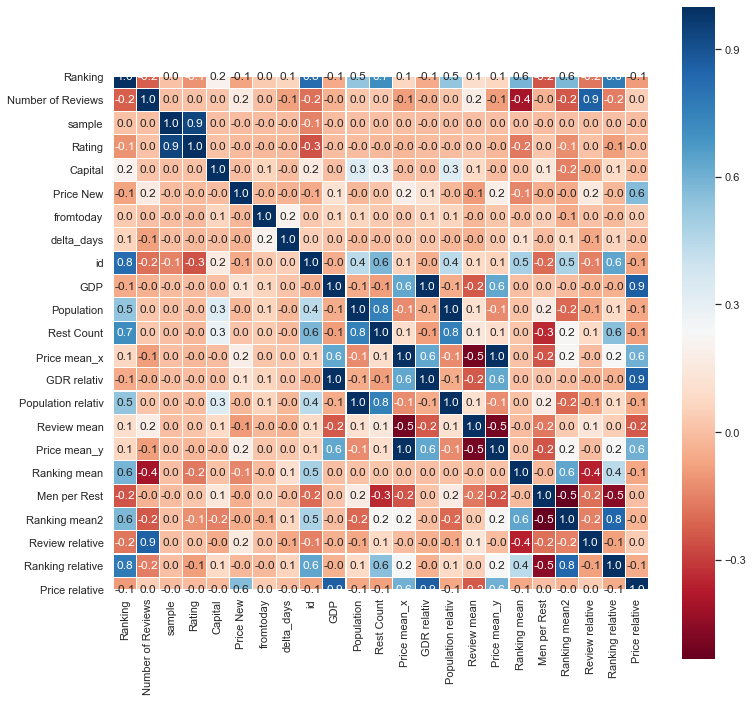

In [177]:
# Посмотрим, есть ли какие корреляции среди наших переменных. А то может зря я все выше налепил!)

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [178]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Capital', 'Price New', 'fromtoday', 'delta_days', 'id', 'GDP',
       'Population', 'Rest Count', 'Price mean_x', 'GDR relativ',
       'Population relativ', 'Review mean', 'Price mean_y', 'Ranking mean',
       'Men per Rest', 'Ranking mean2', 'Review relative', 'Ranking relative',
       'Price relative'],
      dtype='object')

In [179]:
# Итак нам определенно не нужны следующие колонки: Ranking relative, Review relative, Rest Count, Population relativ,
# GDR relativ, Price mean_x

df = df.drop(['Ranking relative','Review relative','Rest Count','Population relativ',
         'GDR relativ','Price mean_x', 'Price mean_y', 'Price relative', 'Ranking mean2'],axis=1)

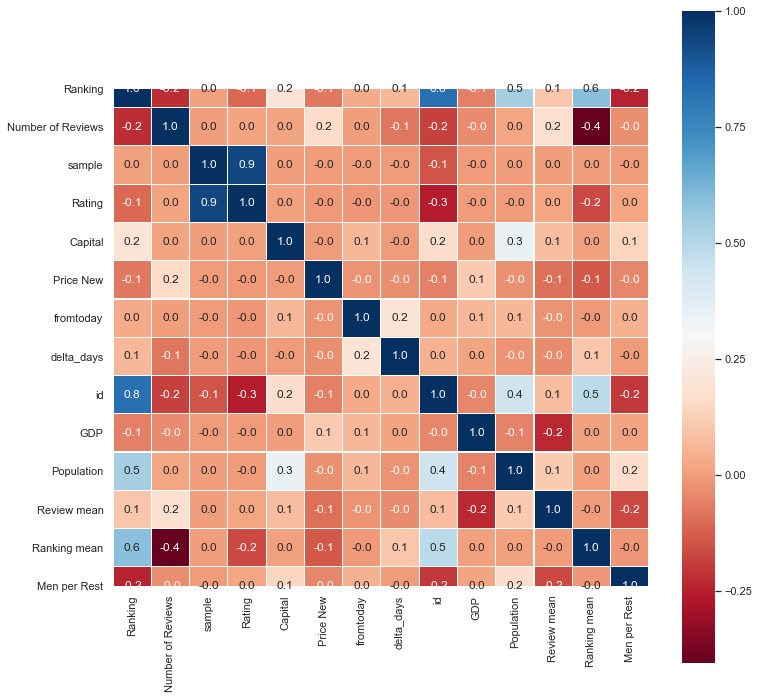

In [180]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [181]:
# Добавим еще парочку искусственных фитч

df['Ranking mean log'] = df['Ranking mean'].apply(lambda x: np.log(x))
df['Number of Reviews log'] = df['Number of Reviews'].apply(lambda x: np.log(x))

In [182]:
# Создадим думисы для City
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

# Создадим думисы для Cuisine Style
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
DummCuisin = pd.DataFrame(mlb.fit_transform(df['Cuisine Style']))

In [183]:
# Удаляем колонки с данными типа object
object_columns = [s for s in df.columns if df[s].dtypes == 'object']

df.drop(object_columns, axis = 1, inplace=True)

In [184]:
df

,Ranking,Number of Reviews,sample,Rating,Capital,Price New,fromtoday,delta_days,id,GDP,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,12963.0,4.0,0,0.0,1,2.000000,0.0,0.0,0,41760,...,0,0,1,0,0,0,0,0,0,0
1,106.0,97.0,0,0.0,1,2.000000,916.0,37.0,1,48868,...,0,0,0,0,0,0,0,0,0,0
2,810.0,28.0,0,0.0,1,2.000000,893.0,22.0,2,42500,...,0,0,0,0,0,0,0,0,0,0
3,1669.0,202.0,0,0.0,1,3.000000,915.0,14.0,3,41030,...,0,0,0,0,0,0,0,0,0,0
4,37.0,162.0,0,0.0,1,3.000000,851.0,15.0,4,19547,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,0,2.000000,905.0,34.0,499,32946,...,0,0,0,0,0,0,0,0,0,0
49996,6341.0,542.0,1,3.5,1,2.000000,900.0,9.0,6340,41760,...,0,0,1,0,0,0,0,0,0,0
49997,1652.0,4.0,1,4.5,1,1.942238,1313.0,3127.0,1649,51241,...,0,0,0,0,0,1,0,0,0,0
49998,641.0,70.0,1,4.0,1,2.000000,1063.0,23.0,640,14901,...,0,0,0,0,0,0,0,1,0,0


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 48 columns):
Ranking                  50000 non-null float64
Number of Reviews        50000 non-null float64
sample                   50000 non-null int64
Rating                   50000 non-null float64
Capital                  50000 non-null int64
Price New                50000 non-null float64
fromtoday                50000 non-null float64
delta_days               50000 non-null float64
id                       50000 non-null int64
GDP                      50000 non-null int64
Population               50000 non-null int64
Review mean              50000 non-null float64
Ranking mean             50000 non-null float64
Men per Rest             50000 non-null float64
Ranking mean log         50000 non-null float64
Number of Reviews log    50000 non-null float64
City_Amsterdam           50000 non-null uint8
City_Athens              50000 non-null uint8
City_Barcelona           50000 non-null u

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [186]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [187]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [188]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 47), (40000, 47), (40000, 46), (32000, 46), (8000, 46))

In [189]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [190]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [191]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [192]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [193]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20001124999999997


In [201]:
# Глянем еще среднеквадратичную ошибку:

print('MSE:', metrics.mean_squared_error(y_test, y_pred))

MSE: 0.09271305625


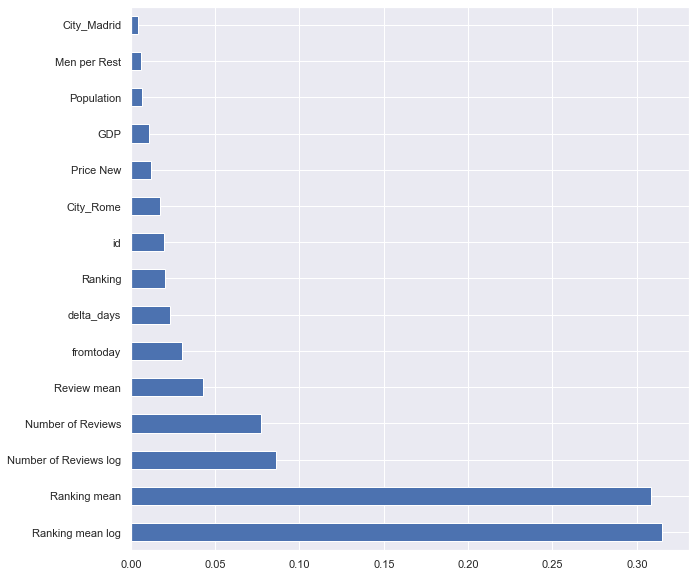

In [202]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Заключение

В целом модель получилась неплохая (наверное:))). Как видим из последнего графика, можно было не городить кучу признаков, а сделать пару основных и на них выстроить модель. При этом, логарифмированные признаки дают большую отдачу, чем простые.